Run a star cluster orbiting the Galaxy
====================

Contrary to common believes and folklore, star clusters are not isolated, but embedded in the potential of the Galaxy et large.
This notion became even more apparent with the measurements of the Gaia sattelite. Here we will simulate the evolution of a star cluster in a background (Galactic) potential.

For reference you can read chapter 7 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- generate inital conditions for star clusters
- to initialize stellar evolution and gravitational N-body codes
- channels and intra-code data transfer
- making a class in Python
- bridge two codes
- plotting results
- making cumulative distributions
- Single-directional hierarchical code coupling strategy (i.e. classice bridge).
- Bridge timesteps.
- Constructing classes in Python
- Incorporating an external potential to an N-body simulation
- Appreciate the role of get_gravity_at_point function in bridge.
- Appreciate the role of get_potential_at_point function in bridge.

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units, constants

We start by creating a class in which we describe the background (static) potential of the Milky way Galaxy.
this is a very simple background potential model, which you can find in [Binney & Trainaine](https://ui.adsabs.harvard.edu/abs/2008gady.book.....B/abstract).
It has components for the bulge, disk and halo.
The coding is a bit arcane, but the routine is short and it has a simple single purpose.

The class definition was quite simple. But the two main routines get_potential_at_point and get_gravity_at_point are the ones that do the job. These routines are used in the integrator the calculate the potential and local gravity at a particular point in space. The format of the argument list of these functions is fixed, because it is used elsewhere in AMUSE for integrating the cluster (which we still have to define).

In [2]:
class MilkyWay_galaxy(object):
    def __init__(self, 
                 Mb=1.40592e10| units.MSun,
                 Md=8.5608e10| units.MSun,
                 Mh=1.07068e11 | units.MSun):
        self.Mb= Mb
        self.Md= Md
        self.Mh= Mh

    def get_potential_at_point(self,eps,x,y,z):
        r=(x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        # buldge
        b1= 0.3873 |units.kpc
        pot_bulge= -constants.G*self.Mb/(r**2+b1**2)**0.5 
        # disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        pot_disk = -constants.G*self.Md/(R**2 + (a2+ (z**2+ b2**2)**0.5 )**2 )**0.5
        #halo
        a3= 12.0 |units.kpc
        cut_off=100 |units.kpc
        d1= r/a3
        c=1+ (cut_off/a3)**1.02
        pot_halo= -constants.G*(self.Mh/a3)*d1**1.02/(1+ d1**1.02) \
                  - (constants.G*self.Mh/(1.02*a3))\
                      * (-1.02/c +numpy.log(c) + 1.02/(1+d1**1.02) \
                           - numpy.log(1.0 +d1**1.02) )
        return 2*(pot_bulge+pot_disk+ pot_halo) 
                # multiply by 2 because it is a rigid potential
    
    def get_gravity_at_point(self, eps, x,y,z): 
        r= (x**2+y**2+z**2)**0.5
        R= (x**2+y**2)**0.5
        #bulge
        b1= 0.3873 |units.kpc
        force_bulge= -constants.G*self.Mb/(r**2+b1**2)**1.5 
        #disk
        a2= 5.31 |units.kpc
        b2= 0.25 |units.kpc
        d= a2+ (z**2+ b2**2)**0.5
        force_disk=-constants.G*self.Md/(R**2+ d**2 )**1.5
        #halo
        a3= 12.0 |units.kpc
        d1= r/a3
        force_halo= -constants.G*self.Mh*d1**0.02/(a3**2*(1+d1**1.02))
       
        ax= force_bulge*x + force_disk*x  + force_halo*x/r
        ay= force_bulge*y + force_disk*y  + force_halo*y/r
        az= force_bulge*z + force_disk*d*z/(z**2 + b2**2)**0.5 + force_halo*z/r 

        return ax,ay,az

In [19]:
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.couple import bridge
star = Particles(1)
star.mass = 1 |units.MSun
star.position = (1.0,0,0) * (8.5 | units.kpc)
star.velocity = (0,-1.0,0) * (220 | units.kms)
converter=nbody_system.nbody_to_si(star.mass.sum(), 
                                   star.position.length())

The single star has a mass, position and velocity. We can now initiate the N-body code, which is not different than what we have already seen.

In [20]:
from amuse.community.hermite.interface import Hermite
gravity_code = Hermite(converter)
gravity_code.particles.add_particles(star)
ch_g2l = gravity_code.particles.new_channel_to(star)

We not initialize the Milky-way back-ground potential code

In [21]:
MWG = MilkyWay_galaxy()

And the bridge.
The latter, in the next snippet, is like an integrator, except that it takes two or more codes to integrate with respect to eachother.
In this case we initalize the bridge and then add a system (the N-body system) to it. The Milky way Galaxy code is added to the bridge as a perturning code. Since there are no particles in the Milky way, they do not require any interaction (they do not need to be updated). For this reason *MWG* is added as a separate argument to the routine *add_system*.

Eventually, we provide a timestep to the bridge. This is the time-scale in which the two systems are integrated. Regretfully, and this is one of the major disadvantages of *bridge* it's timestep has to be set separately. Of course, this can be done automatically in the script, but sometimes it requires some fine-tuning and pre-knowledge in order to find the optimium between perserving energy while integrating the equations of motion and the speed of the calculation.

In [22]:
gravity = bridge.Bridge(use_threading=False)
gravity.add_system(gravity_code, (MWG,) )
gravity.timestep = 20|units.Myr

times = numpy.arange(0., 250, 20) | units.Myr
x = [] | units.kpc
y = [] | units.kpc
for time in times:
    gravity.evolve_model(time)
    #ch_g2l.copy()
    x.append(star[0].x)
    y.append(star[0].y)
#gravity.stop()

And we plot the results.

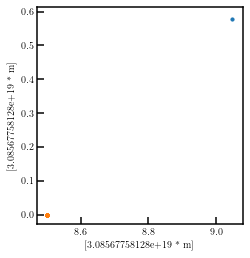

In [24]:
from amuse.plot import plot, scatter
ch_g2l.copy()
scatter(star.x, star.y, s=10)
#plot(x, y, lw=1)
scatter(x, y, s=10)
pyplot.gca().set_aspect("equal", adjustable="box")
pyplot.show()

It looks like we can integrate the orbit of a single star around the Galactic center, and with an orbital velocity of 200km/s the orbit turns out to be circular (or close enough to being circular).

Now, we used a direct N-body code (Hermite) for integrating the single star, which is a bit silly. Of course, we only need to update the star's position and velocity in the potential and integrate those. So long as there are not other stars around, there is no need for a direct N-body code.

On the other hand, the N-body code offers us the opportunity to integrate a cluster of stars, rather than just a single star. In this way, we can study the evolution of a cluster in the Galactic potential.

You have performed a small experiment in which a population of stars was evolved from zero-age to an age of 10Myr.
The stars were selected randomly from a Salpeter mass function, and distributed in a virialized Plummer sphere with a characteristic (Plummer) radius of 1pc.

Assignmnets and questions:
---------------

### Assignment 1:
The output of the figure is not a nice smooth orbit, but a but jagged. Change the script in such a way that the orbit becomes more smooth.

### Assignment 2:
The integration was for an (almost) ciruclar orbit. Sometimes, however, we are interested in more eccentric orbits.
Integrate the orbit of the same star (at a starting distance of 8.5kpc from the Galactic center), but with a velocity in the *y*-direction of *22km/s*.

### Question 1:
If your star escaped the potentical of the Galaxy, why is that the case. What change do you have to make to the script to assure that the orbit is still correct?

### Question 2:
Can you descript the orbit of the star in the eccentric orbit around the Galactic center?

### Assignment 2:
Replace the single star for a cluster of 10 stars with masses from the Salpeter mass function (between 1MSun and 100Msun) in a Plummer sphere with a characteristic radius of 10pc. Run the simulation and plot the cluster center-of-mass while it orbits the Galactic center.

### Question 3: 
Describe what is different on this cluster center-of-mass orbit compared to the orbit of the single star.

### Question 4:
Does the cluster stay bound?

### Assignment 3:
Now change the orbital velocity of the cluster center-of-mass to 22km/s, as you did before in assignment 2, and redo the calculation.
run the script again and describe how different the cluster orbit is not compared to the orbit of the single star.

### Question 5:
At what point in time does the cluster become unbound?

### Assignment 4:
Redo the calculation of the cluster with 10 stars in an eccentric orbit around the Galactic center, but with a slightly different orbital velocity for each calculation, ranging from 22km/s, 44km/s, 66km/s, up to 440km/s.

While doing the calculation the shortest distance of the cluster center to the Galactic center and measure the moment the cluster becomes unbound.

 - Plot the distance of closest approach as a function of the initial orbital velocity of the cluster.
 
 - Plot the moment the cluster dissolves as a function of its initial orbital velocity.

**Make sure that you use the same cluster for each calculation.**

### Question 6:
At what speed does the cluster escape the Galaxy?
And show with theoretical arguments that you could have expected this to happen at that particular speed.

### Question 7:
Explain the curve from plotting the cluster dissolution time as function of its orbital velocity in the Galactic potential.